<a href="https://colab.research.google.com/github/pavlo-seimskyi/nlp-sentiment-analysis/blob/main/sentiment-analysis-nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TL;DR**
Logistic Regression and [BERT](https://huggingface.co/bert-base-uncased) models were trained on 110,000 training examples of the `Sentiment140-train` dataset and evaluated on `Sentiment-140-valid` (10% or 11,000 examples from the training set), `Sentiment140-test`, and `Dublin City Council` datasets.

**Main challenges**:
- Training data contains *2 labels* (`negative/positive`) while the test data contains *3* (`negative/positive/neutral`). The accuracy drops dramatically from binary to 3-label-classification.
- Dublin City Council is out-of-domain data and differs notably from the training data, especially in the formality of the language.

**Decisions taken along the process**:
- Since the training set only contained labels `0` and `4`, labels `4` were converted into `1` for convenience.
- To convert the model from binary into 3-label-classifier, the prediction probabilities were tested against a `threshold`. If the model's prediction certainty/probability is low (i.e. the model is not very confident about its prediction), the prediction was set to `2` or `neutral`. This improved the accuracy by +2.2% on the final test set for Logistic Regression but almost did not improve it for BERT (+0.03%).
- To understand why the models made errors, I found top losses for each test example (both Sentiment140 and Dublin City council data), i.e. cases when the model was very confident in its prediction but it was incorrect. 
- Additionally, in case of Logistic Regression, for each token in top loss examples, I printed the model coefficients to see how the token impacted the final score.
- I used a dropout layer (`p=30%`) as regularization and a linear + softmax layer on top of the BERT's encoder to convert the raw pooled output into labels `0` and `1` (recommended by the original research paper).

**Results**:
- `Sentiment140-valid:           LogReg 74% | BERT 85%`
- `Sentiment140-test (2 labels): LogReg 77% | BERT 82%`
- `Sentiment140-test (3 labels): LogReg 57% | BERT 60%`
- `Dublin-test (2 labels):       LogReg 67% | BERT 66%`
- `Dublin-test (3 labels):       LogReg 47% | BERT 44%`

## 1. Baseline
Before using Machine Learning at all, I used a simple dummy approach to see the minimum possible accuracy that I can get. Logic: For each word in the corpus, 2 different scores were given: How many times this word appeared in negative tweets, and how many times in positive tweets. To make prediction, I simply summed the negative and the positive scores across each word >>> If negative sum is higher, predict `negative` and vice versa. This approach gave 65% accuracy on the unseen training data, so I knew that this is the minimum that I need to aim for on the validation set.

## 2. Logistic Regression
To convert text into numbers, I used TF-IDF for text vectorization. Only 1,000 maximally relevant tokens/words were kept. Different hyperparameters were tested with `Grid Search` on a small subset of training examples and later used in training the model on more data. To use the model as a 3-label-classifier, the prediction probabilities were compared against a threshold , the predictions were set to `neutral`.

## 3. BERT
Pretrained [BERT model](https://huggingface.co/bert-base-uncased) in combination with pretrained tokenizer (both are `bert-base-uncased`) was used as the final model. I used a dropout layer with probability of 30% as regularization and a softmax layer on top of the model's encoder to convert the pooled output into labels `0` and `1`. This architecture was chosen because it is recommended in the [original research paper](https://arxiv.org/abs/1810.04805). BERT was fine-tuned during 10 epochs and the parameters that proved the best accuracy on the validation set were saved. The same approach was used to convert BERT into 3-label-classifier as with LogReg.


**Error analysis and interesting observations**:
- Either the annotation quality is below desired or the model has difficulties recognizing **ironic/sarcastic** sentences. Example - Tweet with id `2327969640` seems to convey a positive sentiment while carrying a negative label: 
```
@personalhudgens aww i bet i'm good thank you x
```
- Emojis could help to recognize sarcastic tweets if they were preprocessed properly. Examples:
```
Correct label: 0 | Prediction: 1
Tokenized text: @kirstiealley my dentist is great (0.15) but she 's (-0.01) expensive … (-0.07) =(
```
```
Correct label: 0 | Prediction: 1
Tokenized text: xxmaj night (0.02) at the xxmaj museum tonite instead (-0.0) of xxup up . (-0.03) :( oh (-0.04) well . (-0.03) that 4 (-0.03) yr old (-0.0) better (0.06) enjoy (0.09) it . (-0.03) xxup lol (0.1)
```
```
Correct label: 1 | Prediction: 0
Tokenized text: xxmaj class (-0.02) … (-0.07) xxmaj the 50d is supposed (-0.04) to come (-0.01) today (-0.03) :)
```
- Many emoticons mean the same thing but are not recognized as such. Like `=)`, `:-)` and `:)`. Other emoticons are not recognized at all (like ❤️ ) while they carry a lot of meaning.
- In case of logistic regression, certain numbers have negative sentiment which does not really make sense.
- Both models' accuracy was **lower** on topics of `Mobility`, `Health`, `Safety`, `Housing`, `Infrastructure` for Dublin City Council test set, and **higher** for `Public Spaces`, `Tourism and Hospitality` and `Community and Culture`. This might because Dublin's spheres of mobility, infrastructure and housing are very special to the city and cannot be generalized well from data from other places.

**`[INSERT ACCURACY BY CATEGORY]`**

**Model's improvement suggestions**:
- First and foremost, the model should be trained on data with 3 labels, not with 2. It might be most helpful to hire some freelancers to annotate `neutral` tweets to get high quality data.
- Edit the preprocessing steps. A code example of the implementation of these improvements is in the end of the notebook (`Research questions` section):
  - Replace hyperlinks with special tokens (like `xxhyperlink`).
  - Replace all the different numbers with a single token (like `xxnumber`).
  - Preprocess emojis and convert other html symbols into recognizable tokens (Convert `:)`, `=)`, `:-)`, etc. into the same token `xxsmileemoji` and `&#10084;` and `<3` into `xxheart`).
  - It would be probably better to remove the remaining punctuation altogether.
- To address the domain differences between Sentiment140 and Dublin City Council datasets, a self-supervised [language model](https://www.d2l.ai/chapter_recurrent-neural-networks/language-models-and-dataset.html) (that predicts the next word in the sentence) could be trained on unlabeled tweets scraped specifically from Dublin area. This model could be used as the pretrained model for classification later, instead of the original pretrained `BERT-base-uncased`. This technique has proved itself quite well in similar classification tasks.
- The results would improve slightly if it was trained on more training examples. I stopped with 110,000 because with more it would have taken more time than was possible to use Google Colab. But from my observations, the results increased by only 1-2% by going from 10,000 to 110,000 examples.
- Spend more time on tweaking the models' hyperparameters. For Logistic Regression, `GridSearchCV` with a small set of parameters was used to find the best ones on 200 training examples (otherwise, it took too long with 1,000 features). More data could be used as well as bigger set of parameters tested. For BERT, different dropout rates as well as learning rates could be tested.

**Author**: [Pavlo Seimskyi](mailto:pavlo@dataforfuture.org)

In [ ]:
%%capture
!pip install fastai==2.1.10
!pip install transformers

In [ ]:
from fastai.text.all import *
from torch.nn.utils.rnn import pad_sequence
import seaborn as sns
import matplotlib.pyplot as plt
import re                                  
import string

from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer        
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report, f1_score, plot_roc_curve, plot_precision_recall_curve, log_loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!cp "drive/My Drive/Data Science/Citibeats Test/data.zip" .
!unzip data.zip

In [ ]:
df_full = pd.read_csv('data/Sentiment140-train.csv', encoding='ISO-8859-1')
df_full.columns = ['target', 'id', 'date', 'retrieval_query', 'user', 'text_raw']
df_full

,target,id,date,retrieval_query,user,text_raw
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


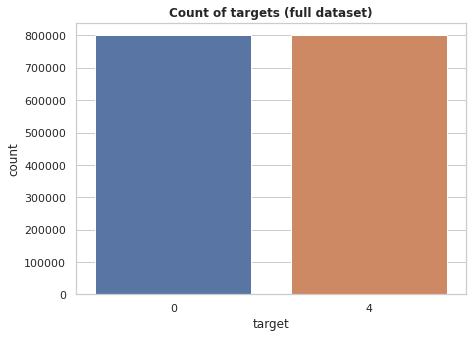

In [ ]:
sns.set(style="whitegrid")
fig,ax = plt.subplots(figsize=(7,5))
ax.set_title('Count of targets (full dataset)', weight=700)
sns.countplot(data=df_full,x='target');

In [ ]:
df_full.text_raw[0]

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

In [ ]:
# Rename the labels: 4 >> 1
df_full['target'] = df_full['target'].replace({4:1})
df_full

,target,id,date,retrieval_query,user,text_raw
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


In [ ]:
# CHANGE THIS
df = df_full.sample(110000, random_state=101)

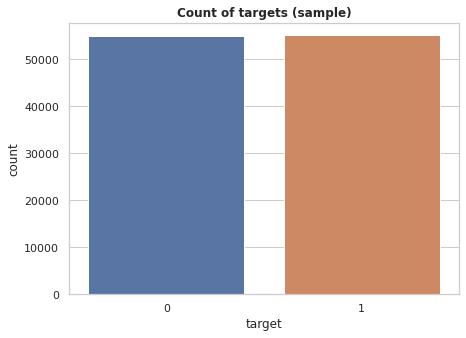

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))
ax.set_title('Count of targets (sample)', weight=700)
sns.countplot(data=df,x='target');

# 1: Use the count of words with pos/neg labels to predict (not ML)

## Preprocessing

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def text_process(tweet):
    tweet = re.sub(r'^RT[\s]+', '', tweet) # remove RT
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', 'hyperlink', tweet) # remove hyperlinks
    tweet = re.sub(r'#', '# ', tweet) # add space after hashtag symbols

    tokenizer = TweetTokenizer()
    tweet_tokenized = tokenizer.tokenize(tweet)

    stopwords_english = stopwords.words('english')

    tweet_processed= [word for word in tweet_tokenized 
                       if word not in stopwords_english 
                       and word not in string.punctuation]

    stemmer = PorterStemmer() 

    tweet_after_stem=[stemmer.stem(word) for word in tweet_processed]
    
    return tweet_after_stem

In [ ]:
text_process(df.text_raw.iloc[12])

["it'",
 'time',
 'I',
 'put',
 'foot',
 'n',
 'end',
 'BS',
 'stress',
 'long',
 'I',
 'need',
 'strenght',
 '2',
 'hate',
 'sad']

### Constructing a vocab with frequencies of words occuring in positive and negative tweets

In [ ]:
def calculate_freqs(all_positive_tweets, all_negative_tweets):
  pos_words=[]
  for tweet in all_positive_tweets:
      tweet=text_process(tweet)
      
      for word in tweet:
          
          pos_words.append(word)
  freq_pos={}
  for word in pos_words:
      if (word,1) not in freq_pos:
          freq_pos[(word,1)]=1
      else:
          freq_pos[(word,1)]=freq_pos[(word,1)]+1
  neg_words=[]
  for tweet in all_negative_tweets:
      tweet=text_process(tweet)
      
      for word in tweet:
          
          neg_words.append(word)
  freq_neg={}
  for word in neg_words:
      if (word,0) not in freq_neg:
          freq_neg[(word,0)]=1
      else:
          freq_neg[(word,0)]=freq_neg[(word,0)]+1
  freqs_dict = dict(freq_pos)
  freqs_dict.update(freq_neg)
  return freqs_dict

In [ ]:
# Only take first 8,000 examples to train, evaluate on 2,000
# We don't need more since this is a dummy approach just to have some baseline
X_train = df.iloc[:8000]
X_test = df.iloc[8000:10000]

In [ ]:
freqs = calculate_freqs(X_train[X_train['target'] == 1]['text_raw'], X_train[X_train['target'] == 0]['text_raw'])

In [ ]:
def get_score(text, freqs=freqs) :
  negative_score = 0; positive_score = 0
  for word in text_process(text) :
    if (word, 0) not in freqs : negative_score += 0
    else: negative_score += freqs[(word, 0)]
  
    if (word, 1) not in freqs : positive_score += 0
    else: positive_score += freqs[(word, 1)]
    
  if negative_score > positive_score : label = 0
  else : label = 1
  return label

In [ ]:
get_score(X_test.iloc[0].text_raw)

0

In [ ]:
get_score(X_test.iloc[2].text_raw)

1

In [ ]:
X_test['pred'] = X_test['text_raw'].apply(get_score)
(X_test['target'] == X_test['pred']).astype(int).sum() / len(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.648

**Output:** With no machine learning involved at all, we are able to predict the sentiment of a tweet with **65% accuracy** (which is already 15% better than simply always predicting 0 or 1!)

# 2: Logistic Regression

## Preprocessing & feature extraction

In [ ]:
# Setting the size of the validation and training sets - 10% / 90%
valid_pct = 0.1
train_pct = 1 - valid_pct

In [ ]:
X_train_raw = df.text_raw.iloc[:int(train_pct*len(df))]
X_valid_raw  = df.text_raw.iloc[int(train_pct*len(df)):]
len(X_train_raw), len(X_valid_raw)

(99000, 11000)

In [ ]:
y_train = df['target'].iloc[:int(train_pct*len(df))]
y_valid  = df['target'].iloc[int(train_pct*len(df)):]
len(y_train), len(y_valid)

(99000, 11000)

In [ ]:
tokenizer = Tokenizer(tok=WordTokenizer)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, tokenizer=tokenizer, max_df=0.6, max_features=1000)
features_train_transformed = vectorizer.fit_transform(X_train_raw)
features_valid_transformed = vectorizer.transform(X_valid_raw)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'nt', 'xxbos'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
features_train_transformed.shape

(99000, 1000)

In [ ]:
scaler = StandardScaler()

In [ ]:
scaled_X_train = scaler.fit_transform(features_train_transformed.toarray())
scaled_X_valid = scaler.transform(features_valid_transformed.toarray())

## Training

In [ ]:
# # Find the best parameters with GridSearchCV
# penalty = ['l1', 'l2', 'elasticnet']
# l1_ratio = np.linspace(0,1,5) # needed for the elasticnet
# C = np.logspace(0,10,5) # recommended as logarithmicly spaced numbers

# param_grid = {'penalty' : penalty,
#               'l1_ratio' : l1_ratio,
#               'C' : C}

# grid_model = GridSearchCV(log_model, param_grid=param_grid)

# grid_model.fit(scaled_X_train, y_train)

# best_params = grid_model.best_params_

# grid_model.best_estimator_

In [ ]:
# Here, let's use the best parameters that were found with the GridSearchCV and train on more data
# l1_ratio is removed because it is only used with elasticnet solver
log_model = LogisticRegression(C=100000.0, class_weight=None, dual=False,
                               fit_intercept=True, intercept_scaling=1, 
                               max_iter=5000, multi_class='auto', n_jobs=None, penalty='l1',
                               random_state=None, solver='saga', tol=0.0001, verbose=0,
                               warm_start=False)

In [ ]:
log_model.fit(scaled_X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = log_model.predict(scaled_X_valid)

In [ ]:
logreg_accuracy_s140_valid = accuracy_score(y_valid, y_pred)
logreg_accuracy_s140_valid

0.7391818181818182

In [ ]:
def show_confusion_matrix(y_true, y_pred, class_names) :
  cm = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')
  plt.show();

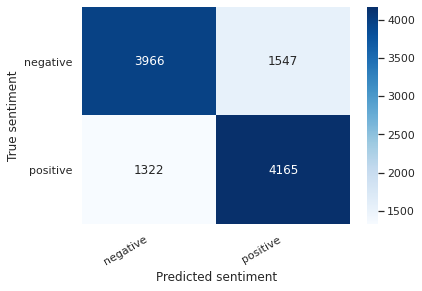

In [ ]:
show_confusion_matrix(y_valid, y_pred, class_names=['negative', 'positive'])

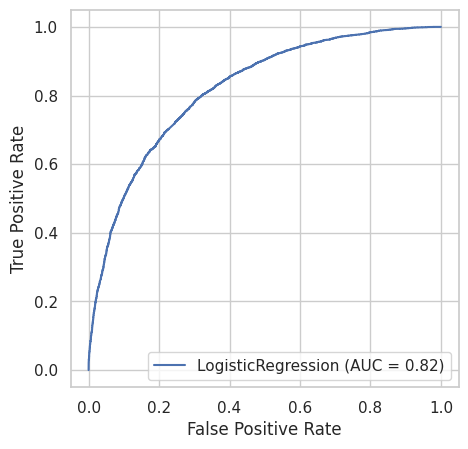

In [ ]:
fig,ax = plt.subplots(figsize=(5,5), dpi=100)
plot_roc_curve(log_model, scaled_X_valid, y_valid, ax=ax)
plt.show()

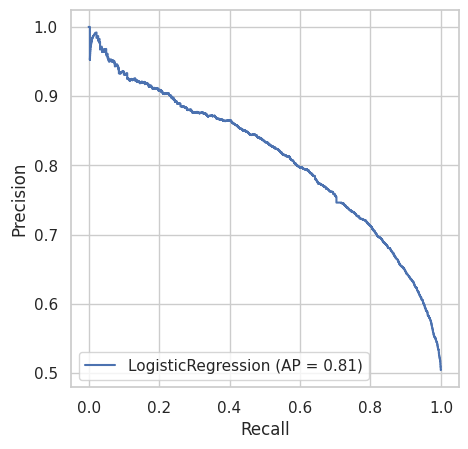

In [ ]:
fig,ax = plt.subplots(figsize=(5,5), dpi=100)
plot_precision_recall_curve(log_model, scaled_X_valid, y_valid, ax=ax)
plt.show()

## Evaluation - Logistic regression

### Sentiment140 Testset

In [ ]:
df_test = pd.read_csv('data/Sentiment140-test.csv', encoding='ISO-8859-1')
df_test.columns = ['target', 'id', 'date', 'retrieval_query', 'user', 'text_raw']
df_test['target'] = df_test['target'].replace({4:1})

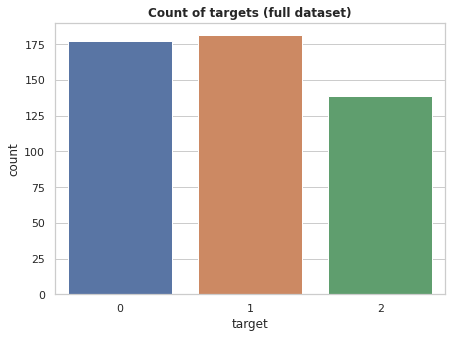

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))
ax.set_title('Count of targets (full dataset)', weight=700)
sns.countplot(data=df_test,x='target');

**Problem:** Label `2` is present in the test dataset, although it was not present in the training dataset.

**Solution:**

If the model's prediction certainty/probability is low (i.e. the model is not very confident about its prediction), we will set the prediction to be `2` or `neutral`.

In [ ]:
# Generating features for test data
X_test_raw = df_test.text_raw
features_test_transformed = vectorizer.transform(X_test_raw)
scaled_X_test = scaler.transform(features_test_transformed.toarray())

# ground truth
y_test = df_test.target

In [ ]:
# Accuracy before implementing this step to compare the results
preds = log_model.predict(scaled_X_test)
logreg_accuracy_s140_test_no_thres = (y_test.values == preds).astype(float).mean()
logreg_accuracy_s140_test_no_thres

0.5533199195171026

In [ ]:
# This will return a prediction with label "2" if the probability is below certain threshold
def get_custom_pred(probs, threshold):
  preds = []
  for prob in probs :
    if prob[prob.argmax()] < threshold : preds.append(2)
    else: preds.append(prob.argmax())

  return np.array(preds)

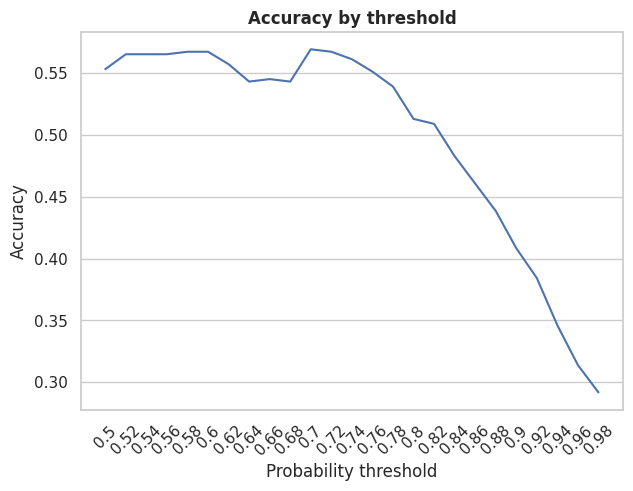

In [ ]:
test_probs = log_model.predict_proba(scaled_X_test)

accs = []
highest_acc = 0
best_thres = 0

thresholds = np.arange(0.5, 0.99, 0.02)
for threshold in thresholds :
  preds = get_custom_pred(test_probs, threshold)
  acc = accuracy_score(y_test, preds)
  if acc > highest_acc : 
    highest_acc = acc
    best_thres = threshold
  accs.append(acc)

fig,ax = plt.subplots(figsize=(7,5), dpi=100)
ax.plot(np.array(accs))

ax.set_xticks(range(len(thresholds)));
ax.set_xticklabels(np.round(thresholds, 2), rotation=45)
ax.set_ylabel('Accuracy'); ax.set_xlabel('Probability threshold')
ax.grid(axis='x')
ax.set_title('Accuracy by threshold', weight=700)
plt.show()

In [ ]:
best_thres

0.7000000000000002

In [ ]:
threshold = best_thres
preds = get_custom_pred(test_probs, best_thres)

print(classification_report(y_test, preds, target_names=['negative', 'positive', 'neutral']))

              precision    recall  f1-score   support

    negative       0.89      0.50      0.64       177
    positive       0.60      0.64      0.61       181
     neutral       0.39      0.57      0.46       139

    accuracy                           0.57       497
   macro avg       0.62      0.57      0.57       497
weighted avg       0.64      0.57      0.58       497



In [ ]:
logreg_accuracy_s140_test = (y_test.values == preds).astype(float).mean()
logreg_accuracy_s140_test

0.5694164989939637

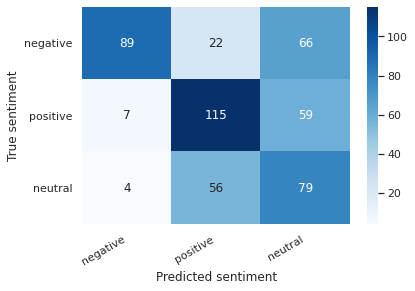

In [ ]:
show_confusion_matrix(y_test.values, preds, class_names=['negative', 'positive', 'neutral'])

Overall model's performance is quite poor: 53%. However, it is still better than simply always guessing the same label `1` (36%).

### Top losses evaluation - Sentiment140

Here, we will investigate on 10 examples with highest losses from the Sentiment140 **`test set`**. I will remove the neutral label to evaluate the model in a fair way. And try to find why the model made incorrect predictions while being very confident in its prediction.

In [ ]:
# Generating features for test data
X_test_raw = df_test[~(df_test['target'] == 2)].text_raw
features_test_transformed = vectorizer.transform(X_test_raw)
scaled_X_test = scaler.transform(features_test_transformed.toarray())

# ground truth
y_test = df_test[~(df_test['target'] == 2)].target

In [ ]:
y_preds = log_model.predict(scaled_X_test)

In [ ]:
logreg_accuracy_s140_test_binary = (y_preds == y_test).astype(float).mean()
logreg_accuracy_s140_test_binary

0.7681564245810056

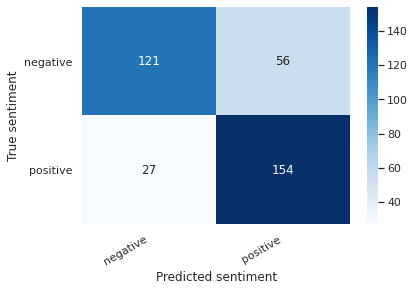

In [ ]:
show_confusion_matrix(y_test.values, y_preds, class_names=['negative', 'positive'])

In [ ]:
# Find top losses (20)
num_examples = 20

preds = log_model.predict(scaled_X_test)
probs = log_model.predict_proba(scaled_X_test)

losses = np.array([])
for prob, y in zip(probs, y_test.values) :
  loss = log_loss(y.reshape(-1,1), prob.reshape(1,-1), labels=[0,1])
  losses = np.append(losses, loss)

# Find indices of top losses
top_losses_ind = np.argpartition(losses, -num_examples)[-num_examples:]

# Only leave the corresponding predictions
preds = preds[top_losses_ind]

In [ ]:
# Sanity check - all these values should be predicted wrongly - Accuracy of 0.
loss_texts = df_test[~(df_test['target'] == 2)].text_raw.iloc[top_losses_ind]
loss_targets = df_test[~(df_test['target'] == 2)].target.iloc[top_losses_ind]

loss_X = vectorizer.transform(loss_texts)
loss_X = scaler.transform(loss_X.toarray())

(loss_targets == log_model.predict(loss_X)).mean() # Should output 0.0

0.0

In [ ]:
# Get coefficients
coef = log_model.coef_

# Transform texts with highest loss into feature vectors
features = pd.DataFrame(vectorizer.transform(loss_texts).toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
full_features = features.columns
#features = features_orig.copy()

# Remove features that do not appear in texts
for col in features.columns:
    if features[col].sum() == 0.0 : features.drop(columns=[col], inplace=True)

# Get coefficients for the features that are left
feature_ind = np.array([np.where(full_features == feature)[0][0] for feature in features.columns])
feature_coef = np.array([coef[:,ind] for ind in feature_ind]).squeeze()
feature_coef = pd.DataFrame(data=feature_coef, index=features.columns, columns=['coefficient'])

In [ ]:
# This will show the coefficients for each word/token if available
# Some words/tokens will have no coefficients assigned because the vectorizer only chooses 1,000 most important ones
# Positive coefficients tip the prediction to label "1" and vice versa
for i, text in enumerate(loss_texts) :
  transformed_texts = np.array([])
  tokens = tokenizer(text)

  for token in tokens :
    transformed_texts = np.append(transformed_texts, token)
    try : 
      weight = feature_coef.loc[token]
      transformed_texts = np.append(transformed_texts, str(f'({np.round(weight.values[0], 2)})'))
    except : continue
  print('Correct label: ' + f'{loss_targets.iloc[i]}\nPrediction: {preds[i]}\nText: ' + ' '.join(transformed_texts[1:]) + '\n')

Correct label: 0
Prediction: 1
Text: i xxmaj will xxup never xxmaj buy (-0.01) a xxmaj government xxmaj motors xxmaj vehicle : (0.03) xxmaj until just (0.04) recently , (0.09) i drove xxup gm cars . (-0.02) xxmaj since 1988 , (0.09) when i bought (0.01) a .. (-0.02) http (0.04) : (0.03) / (0.02) / (0.02) tinyurl.com (0.01) / (0.02) lulsw8

Correct label: 0
Prediction: 1
Text: xxmaj talk (-0.01) is xxmaj cheap : (0.03) xxmaj bing that , (0.09) xxmaj i?ll stick with xxmaj google (0.02) . (-0.02) http (0.04) : (0.03) / (0.02) / (0.02) bit.ly (0.0) / (0.02) xxup xc3c8

Correct label: 0
Prediction: 1
Text: xxmaj listening (0.07) to xxmaj obama … (-0.07) xxmaj friggin xxmaj north xxmaj korea … (-0.07)

Correct label: 0
Prediction: 1
Text: xxmaj cheney and xxmaj bush are the real (0.01) culprits - (0.06) http (0.04) : (0.03) / (0.02) / (0.02) fwix.com / (0.02) article / (0.02) 939496

Correct label: 1
Prediction: 0
Text: xxmaj class (-0.02) … (-0.07) xxmaj the 50d is supposed (-0.03) to come 

Observations:
- Weather seems to impact the sentiment quite a lot: `raining` has negative coefficient of `-0.45` while `sun` has a positive one of `0.06`.
- The found examples could be easily classified with the opposite labels, in my opinion. Like `@personalhudgens aww i bet  i'm good thank you x` seems to convey a positive sentiment while having a negative label.
- `!` Exclamation mark seems to carry positive meaning to it.


### Dublin City Council Testset - Logistic Regression

In [ ]:
dublin = pd.read_csv('data/citypulse.dublin_city_council.test.csv')

In [ ]:
dublin.head()

,id_str,text,created_at,user,sentiment,category,dataset,id
0,1190647458608635904,@DanMulhall @EamonnMallie @MoLI_Museum .@DubCityCouncil #parks dept does great job all year round. Grma - I regularly walk through St Stephen’s Green &amp; am always grateful #Dublin,2019-11-02T15:10:49+00:00,NaN,positive,Public Spaces,Dublin City,1678054821
1,1136601736016224256,Love my city and community!! Rallying together for what is right 👏🏽👏🏽👏🏽👏🏽 @selenatwest @NinaWest \n\nSupporters rally outside Delaware Drag 101 class https://t.co/sCNRDZ9cvp,2019-06-06T11:52:25+00:00,NaN,positive,Community and Culture,Dublin City,810929040
2,1180110345052012545,"Bringing shared #micromobility e-bike &amp; e-scooter solutions to bear on Dublin’s traffic congestion, will help our ranking enormously\n\nLooking forward to @Dub_Bleeper @MobyMove new schemes + arrival of shared scooter operators in time also @smartdublin @jcudden @LordMayorDublin https://t.co/Adw9XsJOTQ",2019-10-04T13:20:06+00:00,NaN,positive,Mobility,Dublin City,1650368993
3,1185632195664330752,"@rothairisbeoir @__kbaker__ @cullen_ellen @willdesigndub @dublincycling @DubCityCouncil Aw man. And there I was, for just a moment, so happy.",2019-10-19T19:01:58+00:00,NaN,positive,Mobility,Dublin City,1657921807
4,1162620823682932737,@OConnorOisin @TUDublinEPS @IrishPedestrian @LorraineFitzsim @UCDRUP @DublinCommuters High Street .. 6 lane urban motorway through Medieval city,2019-08-17T07:02:59+00:00,NaN,positive,Mobility,Dublin City,1514423883


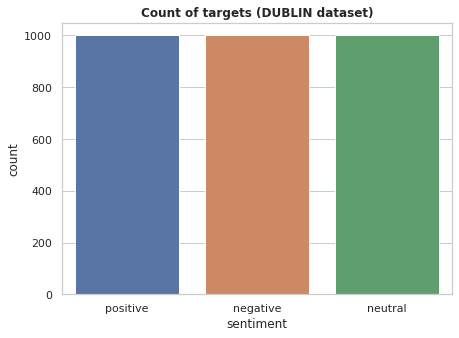

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))
ax.set_title('Count of targets (DUBLIN dataset)', weight=700)
sns.countplot(data=dublin,x='sentiment', ax=ax);

In [ ]:
dublin.loc[dublin.sentiment == 'negative', 'sentiment'] = 0
dublin.loc[dublin.sentiment == 'positive', 'sentiment'] = 1
dublin.loc[dublin.sentiment == 'neutral', 'sentiment'] = 2

In [ ]:
# Generating features for Dublin test data
X_dublin_raw = dublin.text.values
features_dublin_transformed = vectorizer.transform(X_dublin_raw)
scaled_X_dublin = scaler.transform(features_dublin_transformed.toarray())

# ground truth
y_dublin = dublin.sentiment.values.astype(int)

In [ ]:
# Accuracy before implementing the step with threshold to compare the results
preds_dublin = log_model.predict(scaled_X_dublin)
logreg_accuracy_dublin_test_no_thres = (y_dublin == preds_dublin).astype(float).mean()
logreg_accuracy_dublin_test_no_thres

0.44466666666666665

In [ ]:
test_probs_dublin = log_model.predict_proba(scaled_X_dublin)

threshold = best_thres
preds_dublin = get_custom_pred(test_probs_dublin, threshold)

print(classification_report(y_dublin, preds_dublin, target_names=['negative', 'positive', 'neutral']))

              precision    recall  f1-score   support

    negative       0.64      0.28      0.39      1000
    positive       0.57      0.38      0.46      1000
     neutral       0.39      0.74      0.51      1000

    accuracy                           0.47      3000
   macro avg       0.53      0.47      0.45      3000
weighted avg       0.53      0.47      0.45      3000



In [ ]:
logreg_accuracy_dublin_test_full = (y_dublin == preds_dublin).astype(float).mean()
logreg_accuracy_dublin_test_full

0.467

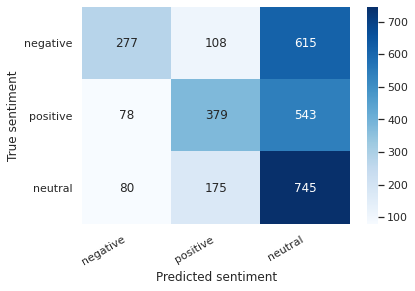

In [ ]:
show_confusion_matrix(y_dublin, preds_dublin, class_names=['negative', 'positive', 'neutral'])

### Top losses evaluation - Dublin City Council

In [ ]:
# Generating features for test data
X_test_raw = dublin[~(dublin['sentiment'] == 2)].text
features_test_transformed = vectorizer.transform(X_test_raw)
scaled_X_test = scaler.transform(features_test_transformed.toarray())

# ground truth
y_test = dublin[~(dublin['sentiment'] == 2)].sentiment

In [ ]:
y_preds = log_model.predict(scaled_X_test)

In [ ]:
logreg_accuracy_dublin_test_binary = (y_preds == y_test.values).astype(float).mean()
logreg_accuracy_dublin_test_binary

0.667

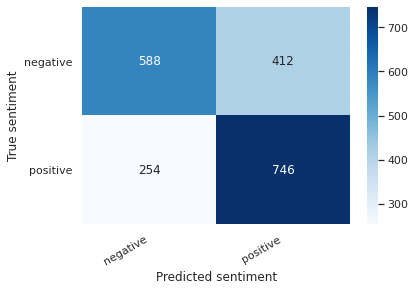

In [ ]:
show_confusion_matrix(y_test.values.astype(int), y_preds, class_names=['negative', 'positive'])

In [ ]:
# Find top losses (10)
num_examples = 10

preds = log_model.predict(scaled_X_test)
probs = log_model.predict_proba(scaled_X_test)

losses = np.array([])
for prob, y in zip(probs, y_test.values) :
  loss = log_loss(np.array(y).reshape(1,1), prob.reshape(1,-1), labels=[0,1])
  losses = np.append(losses, loss)

# Find indices of top losses
top_losses_ind = np.argpartition(losses, -num_examples)[-num_examples:]

# Only leave the corresponding predictions
preds = preds[top_losses_ind]

In [ ]:
# Sanity check - all these values should be predicted wrongly - Accuracy of 0.
loss_texts = dublin[~(dublin['sentiment'] == 2)].text.iloc[top_losses_ind]
loss_targets = dublin[~(dublin['sentiment'] == 2)].sentiment.iloc[top_losses_ind]

loss_X = vectorizer.transform(loss_texts)
loss_X = scaler.transform(loss_X.toarray())

(loss_targets == log_model.predict(loss_X)).mean() # Should output 0.0

0.0

In [ ]:
# Get coefficients
coef = log_model.coef_

# Transform texts with highest loss into feature vectors
features = pd.DataFrame(vectorizer.transform(loss_texts).toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
full_features = features.columns
#features = features_orig.copy()

# Remove features that do not appear in texts
for col in features.columns:
    if features[col].sum() == 0.0 : features.drop(columns=[col], inplace=True)

# Get coefficients for the features that are left
feature_ind = np.array([np.where(full_features == feature)[0][0] for feature in features.columns])
feature_coef = np.array([coef[:,ind] for ind in feature_ind]).squeeze()
feature_coef = pd.DataFrame(data=feature_coef, index=features.columns, columns=['coefficient'])

In [ ]:
# This will show the coefficients for each word/token if available
# Some words/tokens will have no coefficients assigned because the vectorizer only chooses 1,000 most important ones
# Positive coefficients tip the prediction to label "1" and vice versa
for i, text in enumerate(loss_texts) :
  transformed_texts = np.array([])
  tokens = tokenizer(text)

  for token in tokens :
    transformed_texts = np.append(transformed_texts, token)
    try : 
      weight = feature_coef.loc[token]
      transformed_texts = np.append(transformed_texts, str(f'({np.round(weight.values[0], 2)})'))
    except : continue
  print('Correct label: ' + f'{loss_targets.iloc[i]}\nPrediction: {preds[i]}\nText: ' + ' '.join(transformed_texts[1:]) + '\n')

Correct label: 1
Prediction: 0
Text: @tallaghtcomco xxmaj there ’ll be no green (0.01) spaces left (-0.08) soon (0.01) and the roads ca (-0.08) nt (-0.2) handle the additional traffic (-0.03) 😡

Correct label: 1
Prediction: 0
Text: 13th xxmaj july (-0.01) 1919 
 xxmaj mullingar 
 xxmaj in the early (-0.04) hours (-0.02) of the morning (0.04) a baton charge is made against a group of xxmaj sinn xxmaj féin supporters in the xxmaj westmeath town (0.0) . (-0.02) xxmaj two police officers are hit (-0.01) with revolver shots and are being treated in hospital (-0.08)

Correct label: 0
Prediction: 1
Text: xxmaj if you have a profile (0.01) on @thepracticaldev , (0.09) link (-0.0) it below as a comment (0.01) to this post (0.03) and xxmaj i 'll (0.07) follow (0.06) you ! (0.18) xxmaj i 'm (-0.06) looking (0.0) to expand my following (0.04) base to increase my chances of learning more from the community ! (0.18) xxmaj please xxup rt # (0.01) devcommunity 

 https : (0.03) / (0.02) / (0.02) t.co 

# 3: BERT Transformer

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, BertModel, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split 

## Preprocessing and building dataloaders

In [ ]:
device = torch.device("cuda")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [ ]:
tweets = df.text_raw.values
labels = df.target.values

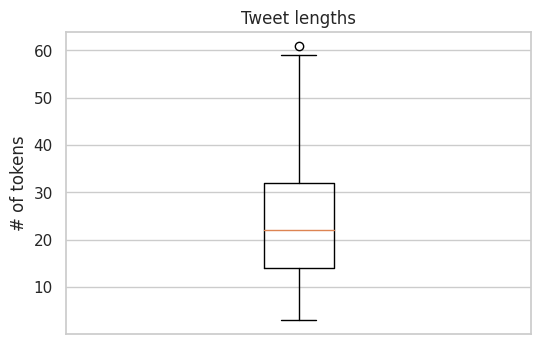

In [ ]:
# Finding the best length to pad/truncate based on sample of first 1,000 tweets
tweet_lengths = [len(tokenizer(tweet)['input_ids']) for tweet in tweets[:1000]]
fig,ax = plt.subplots(dpi=100)
ax.boxplot(tweet_lengths)
ax.grid(axis='x')
ax.set_title('Tweet lengths')
ax.set_xticks([])
ax.set_ylabel('# of tokens')
plt.show()

It seems that around 90-95% of the tweets are of length below 50 tokens. Let's use 50 as the maximum length and pad the shorter tweets to it.

In [ ]:
def tokenizer_encode(tweet) :
  encoded_dict = tokenizer.encode_plus(tweet, 
                                       add_special_tokens = True,       # Add '[CLS]' and '[SEP]'
                                       return_attention_mask = True,    # Do construct attn. masks.
                                       return_token_type_ids = False,   # Do not return token type ids
                                       max_length = 50,                 # max tweet length
                                       padding='max_length',            # Pad to this length if less than 50 tokens
                                       truncation=True,                 # Truncate if the tweet is longer than 50 tokens
                                       return_tensors = 'pt')  
  return encoded_dict

In [ ]:
def encode_data(tweets, labels) :
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  for tweet in tweets:
      encoded_dict = tokenizer_encode(tweet)
      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask']) # attention mask differentiates padding from non-padding

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels

In [ ]:
input_ids, attention_masks, labels = encode_data(tweets, labels)

# Print tweet 0, now as a list of IDs.
print('Original:\n', tweets[0])
print('Token IDs:\n', input_ids[0])

Original:
 So we're here. It's getting cloudy!  Listening to @LBOOGSdotTV on Hot 97.
Token IDs:
 tensor([  101,  2061,  2057,  1005,  2128,  2182,  1012,  2009,  1005,  1055,
         2893, 24706,   999,  5962,  2000,  1030,  6053,  9541,  5620, 27364,
         9189,  2006,  2980,  5989,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(train_size)
print(val_size)

99000
11000


In [ ]:
batch_size = 32

# Training dataloader
train_dataloader = DataLoader(train_dataset,
                              sampler = RandomSampler(train_dataset),
                              batch_size = batch_size)

# Validation dataloader
validation_dataloader = DataLoader(val_dataset, 
                                   sampler = SequentialSampler(val_dataset), # Loading the batches sequentially
                                   batch_size = batch_size)

In [ ]:
for batch in validation_dataloader :
  print(batch[0])
  print(batch[1])
  print(batch[2])
  break

tensor([[  101,  3110,  6517,  ...,     0,     0,     0],
        [  101,  1045,  2123,  ...,     0,     0,     0],
        [  101,  5131,  2026,  ...,     0,     0,     0],
        ...,
        [  101,  4243,  2183,  ...,     0,     0,     0],
        [  101,  2026,  2238,  ...,     0,     0,     0],
        [  101,  1030, 23564,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1])


In [ ]:
class SentimentClassifier(nn.Module) :
  def __init__(self, n_classes) :
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask) :
    _, pooled_output = self.bert(input_ids=input_ids,
                                 attention_mask=attention_mask)
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)

In [ ]:
model = SentimentClassifier(n_classes=2)
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [ ]:
model.bert.config.hidden_size

768

## Training

In [ ]:
epochs = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_dataloader) * epochs

loss_fn = nn.CrossEntropyLoss().to(device)

scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

In [ ]:
def train_epoch(model,
                dataloader,
                loss_fn,
                optimizer,
                device,
                scheduler,
                n_examples) :

  # Activate dropout
  model.train()
  
  losses = []
  correct_predictions = 0

  for batch in dataloader :
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    targets = batch[2].to(device)

    outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask)
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds==targets)
    losses.append(loss.item())

    # Backpropagation step
    loss.backward()

    # This is a way to combat exploding gradients: If they are too large, they can become even larger and "explode"
    # Do inplace, thereofore _ at the end
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, dataloader, loss_fn, device, n_examples) :
  
  # Batch normalization and dropout are disabled
  model.eval()

  losses = []
  correct_predictions = 0

  # Disable gradient function, so that torch is a bit faster
  with torch.no_grad() :
    for batch in dataloader :
      input_ids = batch[0].to(device)
      attention_mask = batch[1].to(device)
      targets = batch[2].to(device)

      outputs = model(input_ids=input_ids,
                      attention_mask=attention_mask)
      
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds==targets)
      losses.append(loss.item())
  
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
# Create dictionary containing lists of losses and accuracies
# Similar to how keras is storing accuracy
# Will be able to choose the best accuracy over the validation set

history = defaultdict(list)
best_accuracy = 0

for epoch in range(epochs) :
  print(f'Epoch {epoch+1}/{epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device,
                                      scheduler=scheduler,
                                      n_examples=len(train_dataset))
  
  print(f'Train loss: {train_loss} Accuracy: {train_acc}')

  val_acc, val_loss = eval_model(model=model,
                                 dataloader=validation_dataloader,
                                 loss_fn=loss_fn,
                                 device=device,
                                 n_examples=len(val_dataset))
  
  print(f'Validation loss: {val_loss} Accuracy: {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy :
    torch.save(model.state_dict(), 'model.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss: 0.4922304785706262 Accuracy: 0.8107272727272727
Validation loss: 0.46438137459200485 Accuracy: 0.8395454545454545

Epoch 2/10
----------
Train loss: 0.4464442453695715 Accuracy: 0.8618585858585859
Validation loss: 0.4597954073444355 Accuracy: 0.848090909090909

Epoch 3/10
----------
Train loss: 0.42325479347010775 Accuracy: 0.8874747474747475
Validation loss: 0.46931133878438974 Accuracy: 0.8397272727272727

Epoch 4/10
----------
Train loss: 0.4097587501301485 Accuracy: 0.9022424242424243
Validation loss: 0.4654028432140517 Accuracy: 0.8455454545454545

Epoch 5/10
----------
Train loss: 0.40211861462614656 Accuracy: 0.9098989898989899
Validation loss: 0.46595607992521554 Accuracy: 0.844

Epoch 6/10
----------
Train loss: 0.39367754309502584 Accuracy: 0.9187474747474748
Validation loss: 0.4645059058486029 Accuracy: 0.8469090909090908

Epoch 7/10
----------
Train loss: 0.38724258751081664 Accuracy: 0.9255656565656566
Validation loss: 0.4647957641891269 A

In [ ]:
tr_acc = np.array(history['train_acc']).reshape(10, 1)
vl_acc = np.array(history['val_acc']).reshape(10, 1)

tr_loss = np.array(history['train_loss']).reshape(10, 1)
vl_loss = np.array(history['val_loss']).reshape(10, 1)

In [51]:
data = np.concatenate((tr_acc, vl_acc, tr_loss, vl_loss), axis=1)
df = pd.DataFrame(data=data, columns=['training_accuracy', 'validation_accuracy', 'training_loss', 'validation_loss'])
df.index = df.index.values + 1

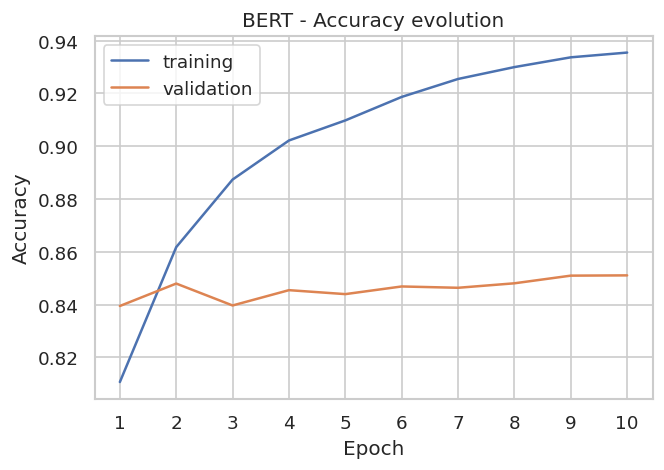

In [59]:
fig,ax = plt.subplots(dpi=120)
sns.lineplot(data=df, x=df.index, y='training_accuracy', ax=ax)
sns.lineplot(data=df, x=df.index, y='validation_accuracy', ax=ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_xticks(np.arange(1,11))
ax.set_xticklabels(np.arange(1,11))
ax.legend(['training', 'validation'])
ax.set_title('BERT - Accuracy evolution')
plt.show();

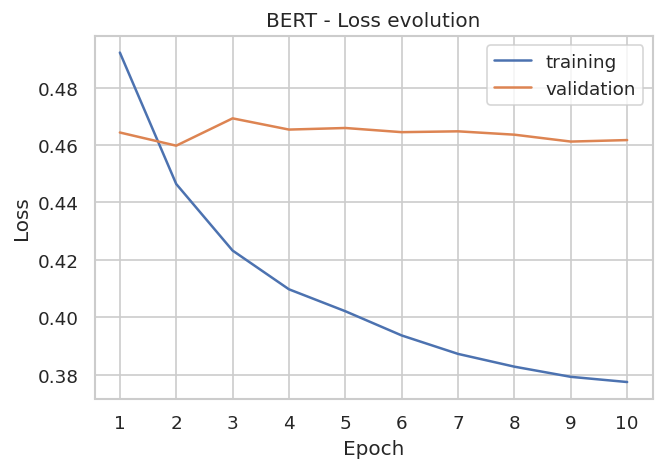

In [60]:
fig,ax = plt.subplots(dpi=120)#figsize=(10,10))
sns.lineplot(data=df, x=df.index, y='training_loss', ax=ax)
sns.lineplot(data=df, x=df.index, y='validation_loss', ax=ax)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_xticks(np.arange(1,11))
ax.set_xticklabels(np.arange(1,11))
ax.legend(['training', 'validation'])
ax.set_title('BERT - Loss evolution')
plt.show();

In [ ]:
os.makedirs('drive/My Drive/Data Science/Citibeats Test/Results', exist_ok=True)
!cp 'model.bin' 'drive/My Drive/Data Science/Citibeats Test/Results/model_110k.bin'

## Load the trained model

In [ ]:
# Load the model's best parameters
!cp 'drive/My Drive/Data Science/Citibeats Test/Results/model_110k.bin' 'model.bin'

In [ ]:
model = SentimentClassifier(n_classes=2)

# To load the parameters
model.load_state_dict(torch.load('model.bin'))

model = model.to(device)

In [ ]:
bert_accuracy_s140_valid, _ = eval_model(model=model,
                                         dataloader=validation_dataloader,
                                         loss_fn=loss_fn,
                                         device=device,
                                         n_examples=len(val_dataset))
bert_accuracy_s140_valid = bert_accuracy_s140_valid.item()
bert_accuracy_s140_valid

0.8511818181818182

## BERT Evaluation

### Sentiment140 Testset - BERT

In [ ]:
# Generating features for test data
X_test_raw = df_test.text_raw

# ground truth
y_test = df_test.target

In [ ]:
test_input_ids, test_attention_masks, test_labels = encode_data(tweets=X_test_raw.values, labels=y_test.values.astype(int))

In [ ]:
# This will return a prediction with label "2" if the model is uncertain about its prediction
def get_custom_pred(probs, threshold):
  preds = []
  for prob in probs :
    if prob[prob.argmax()] < threshold : preds.append(2)
    else: preds.append(prob.argmax())

  return np.array(preds)

In [ ]:
batches = [(batch*batch_size, batch*batch_size+batch_size) for i, batch in enumerate(range(int(len(X_test_raw) / batch_size)))]
batches.append((batches[-1][-1], len(X_test_raw)))

In [ ]:
# This is to compare the performance with/without implementing the threshold to predict neutral class
preds_before_thres = np.array([])
with torch.no_grad() :
  for batch in batches :
    input_ids = test_input_ids[batch[0]:batch[1]].to(device)
    attention_mask = test_attention_masks[batch[0]:batch[1]].to(device)
    targets = test_labels[batch[0]:batch[1]].numpy()

    test_probs = model(input_ids=input_ids,
                        attention_mask=attention_mask)
    
    # This is to compare the performance with/without implementing the threshold to predict neutral class
    new_preds_before_thres = test_probs.argmax(dim=1).cpu().numpy()
    preds_before_thres = np.append(preds_before_thres, new_preds_before_thres)

bert_accuracy_s140_test_no_thres = accuracy_score(y_test, preds_before_thres)
bert_accuracy_s140_test_no_thres

0.5915492957746479

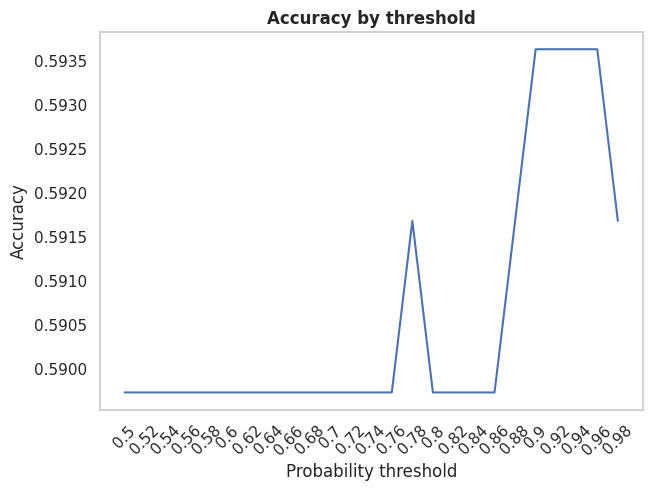

In [ ]:
# This is with the implementation of threshold to predict "neutral"
accs = []
highest_acc = 0
best_thres = 0

thresholds = np.arange(0.5, 0.99, 0.02)
for threshold in thresholds :
  
  acc_batches = []
  with torch.no_grad() :
    for batch in batches :
      input_ids = test_input_ids[batch[0]:batch[1]].to(device)
      attention_mask = test_attention_masks[batch[0]:batch[1]].to(device)
      targets = test_labels[batch[0]:batch[1]].numpy()

      test_probs = model(input_ids=input_ids,
                         attention_mask=attention_mask)

      preds = get_custom_pred(test_probs, threshold)
      preds = np.array([int(pred) for pred in preds])      

      acc_batches.append(accuracy_score(targets, preds))
  acc = np.array(acc_batches).mean()
  if acc > highest_acc : 
    highest_acc = acc
    best_thres = threshold
  accs.append(acc)

fig,ax = plt.subplots(figsize=(7,5), dpi=100)
ax.plot(np.array(accs))
ax.set_xticks(range(len(thresholds)));
ax.set_xticklabels(np.round(thresholds, 2), rotation=45)
ax.set_ylabel('Accuracy'); ax.set_xlabel('Probability threshold')
plt.grid()
plt.title('Accuracy by threshold', weight=700)
plt.show()

In [ ]:
best_thres

0.9000000000000004

In [ ]:
preds = []
for ids, att in zip(test_input_ids, test_attention_masks) :
  ids = ids.unsqueeze(dim=0)
  att = att.unsqueeze(dim=0)
  probs = model(input_ids=ids.to(device),
                attention_mask=att.to(device))

  pred = get_custom_pred(probs, best_thres)
  pred = int(pred)
  preds.append(pred)

In [ ]:
print(classification_report(test_labels.numpy(), preds, target_names=['negative', 'positive', 'neutral']))

              precision    recall  f1-score   support

    negative       0.71      0.79      0.75       177
    positive       0.52      0.85      0.65       181
     neutral       0.50      0.02      0.04       139

    accuracy                           0.60       497
   macro avg       0.58      0.55      0.48       497
weighted avg       0.58      0.60      0.51       497



In [ ]:
bert_accuracy_s140_test = (test_labels.numpy() == preds).astype(float).mean()
bert_accuracy_s140_test

0.5955734406438632

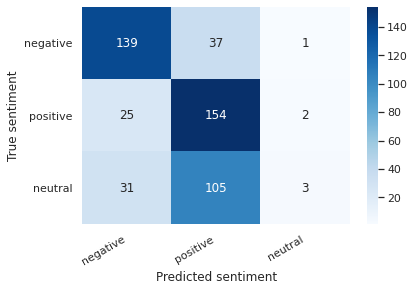

In [ ]:
show_confusion_matrix(test_labels.numpy(), preds, class_names=['negative', 'positive', 'neutral'])

### Top losses evaluation - Sentiment140

In [ ]:
# Getting only samples with labels 0 and 1
X_test_raw = df_test[(df_test['target'] != 2)].text_raw

# Ground truth
y_test = df_test[(df_test['target'] != 2)].target

In [ ]:
test_input_ids, test_attention_masks, test_labels = encode_data(tweets=X_test_raw.values, labels=y_test.values.astype(int))
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(test_dataset, 
                             sampler = SequentialSampler(test_dataset), # Loading the batches sequentially
                             batch_size = 32)

In [ ]:
# Get top losses
preds = []
losses = []
for i, (ids, att) in enumerate(zip(test_input_ids, test_attention_masks)) :
  ids = ids.unsqueeze(dim=0)
  att = att.unsqueeze(dim=0)
  lbl = test_labels[i].to(device)

  probs = model(input_ids=ids.to(device),
                attention_mask=att.to(device))

  pred = probs.argmax(dim=1)
  preds = np.append(preds, pred.cpu().numpy().astype(int))

  loss = loss_fn(probs, lbl.unsqueeze(dim=0)).item()
  losses.append(loss)

In [ ]:
bert_accuracy_s140_test_binary = (y_test.values == preds).astype(float).mean()
bert_accuracy_s140_test_binary

0.8212290502793296

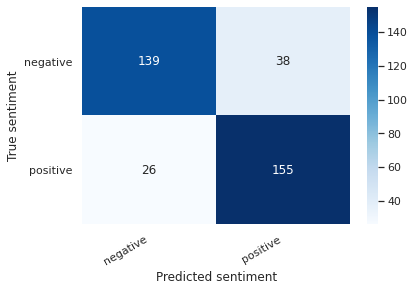

In [ ]:
show_confusion_matrix(y_test.values, preds, class_names=['negative', 'positive'])

In [ ]:
losses = np.array(losses)

In [ ]:
# Find top losses (10)
num_examples = 10

# Find indices of top losses
top_losses_ind = np.argpartition(losses, -num_examples)[-num_examples:]

# Only leave the corresponding predictions
top_losses_preds = preds.astype(int)[top_losses_ind]

In [ ]:
# Show texts with highest losses
top_losses_texts = df_test[(df_test['target'] != 2)].iloc[top_losses_ind].text_raw
top_losses_targets = df_test[(df_test['target'] != 2)].iloc[top_losses_ind].target

In [ ]:
# Sanity check - all these values should be predicted wrongly
(top_losses_targets == top_losses_preds).mean() # Should output 0.0

0.0

In [ ]:
top_losses_df = df_test[(df_test['target'] != 2)].iloc[top_losses_ind][['text_raw','target']]
top_losses_df['prediction'] = top_losses_preds
top_losses_df

,text_raw,target,prediction
395,"RT @sportsguy33: New Time Warner slogan: ""Time Warner, where we make you long for the days before cable.""",0,1
330,"I just realized we three monkeys in the white Obama.Biden,Pelosi . Sarah Palin 2012",0,1
17,"@ludajuice Lebron is a Beast, but I'm still cheering 4 the A..til the end.",0,1
94,omgg i ohhdee want mcdonalds damn i wonder if its open lol =],1,0
343,Colin Powell rocked yesterday on CBS. Cheney needs to shut the hell up and go home.Powell is a man of Honor and served our country proudly,0,1
21,@wordwhizkid Lebron is a beast... nobody in the NBA comes even close.,1,0
461,"Today is a good day to dislike AT&amp;T. Vote out of office indeed, @danielpunkass",0,1
297,The day I never have to deal with Comcast again will rank as one of the best days of my life.,0,1
275,SOOO DISSAPOiNTED THEY SENT DANNY GOKEY HOME... YOU STiLL ROCK ...DANNY ... MY HOMETOWN HERO !! YEAH MiLROCKEE!!,1,0
255,@uscsports21 LeBron is a monsta and he is only 24. SMH The world ain't ready.,1,0


In [ ]:
for i, text in enumerate(top_losses_texts) :
  transformed_texts = np.array([])
  tokens = tokenizer.tokenize(text)

  for token in tokens :
    transformed_texts = np.append(transformed_texts, token)
  
  print('Correct label: ' + f'{top_losses_targets.iloc[i]}\nPrediction: {top_losses_preds[i]}\nText: ' + ' '.join(transformed_texts) + '\n')

Correct label: 0
Prediction: 1
Text: rt @ sports ##gu ##y ##33 : new time warner slogan : " time warner , where we make you long for the days before cable . "

Correct label: 0
Prediction: 1
Text: i just realized we three monkeys in the white obama . bid ##en , pe ##los ##i . sarah pali ##n 2012

Correct label: 0
Prediction: 1
Text: @ lu ##da ##ju ##ice le ##bron is a beast , but i ' m still cheering 4 the a . . til the end .

Correct label: 1
Prediction: 0
Text: om ##gg i oh ##hd ##ee want mcdonald ##s damn i wonder if its open lo ##l = ]

Correct label: 0
Prediction: 1
Text: colin powell rocked yesterday on cbs . cheney needs to shut the hell up and go home . powell is a man of honor and served our country proudly

Correct label: 1
Prediction: 0
Text: @ word ##w ##hi ##z ##ki ##d le ##bron is a beast . . . nobody in the nba comes even close .

Correct label: 0
Prediction: 1
Text: today is a good day to dislike at & amp ; t . vote out of office indeed , @ daniel ##pu ##nka ##ss

Corre

Observations:

- Example 94: word "damn" many times carries a negative sentiment but is used here in a positive way.
- Example 149: Has a positive ending but is still labelled as negative.
- The pretrained tokenizer does not seem to recognize emojis like `=]`, `:)`, or `:(`.

### Dublin City Council Testset - BERT

In [ ]:
dublin_tweets = dublin.text.values
dublin_labels = dublin.sentiment.values

In [ ]:
dublin_input_ids, dublin_attention_masks, dublin_labels = encode_data(tweets=dublin_tweets, labels=dublin_labels.astype(int))

In [ ]:
threshold = best_thres

preds_before_thres = np.array([])
preds = []

for ids, att in zip(dublin_input_ids, dublin_attention_masks) :
  ids = ids.unsqueeze(dim=0)
  att = att.unsqueeze(dim=0)
  probs = model(input_ids=ids.to(device),
                attention_mask=att.to(device))

  # This is to test the performance with and without the implementation of threshold to predict neutral
  new_preds_before_thres = probs.argmax(dim=1).cpu().numpy()
  preds_before_thres = np.append(preds_before_thres, new_preds_before_thres)

  pred = get_custom_pred(probs, threshold)
  pred = int(pred)
  preds.append(pred)

print(classification_report(dublin_labels.numpy(), preds, target_names=['negative', 'positive', 'neutral']))

              precision    recall  f1-score   support

    negative       0.49      0.58      0.53      1000
    positive       0.41      0.72      0.52      1000
     neutral       0.36      0.02      0.04      1000

    accuracy                           0.44      3000
   macro avg       0.42      0.44      0.36      3000
weighted avg       0.42      0.44      0.36      3000



In [ ]:
bert_accuracy_dublin_test_no_thres = accuracy_score(dublin_labels.cpu().numpy(), preds_before_thres)
bert_accuracy_dublin_test_no_thres

0.439

In [ ]:
bert_accuracy_dublin_test_full = (dublin_labels.numpy() == preds).astype(float).mean()
bert_accuracy_dublin_test_full

0.43933333333333335

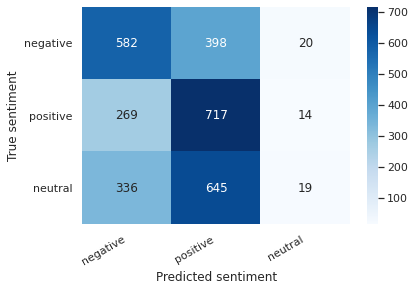

In [ ]:
show_confusion_matrix(dublin_labels, preds, class_names=['negative', 'positive', 'neutral'])

### Top losses evaluation - Dublin City Council

In [ ]:
# Generating features for test data
X_test_raw = dublin[~(dublin['sentiment'] == 2)].text

# ground truth
y_test = dublin[~(dublin['sentiment'] == 2)].sentiment.astype(int)

In [ ]:
dublin_input_ids, dublin_attention_masks, dublin_labels = encode_data(tweets=X_test_raw.values, labels=y_test.values)

In [ ]:
# Get top losses
preds = []
losses = []
for i, (ids, att) in enumerate(zip(dublin_input_ids, dublin_attention_masks)) :
  ids = ids.unsqueeze(dim=0)
  att = att.unsqueeze(dim=0)
  lbl = dublin_labels[i].to(device)

  probs = model(input_ids=ids.to(device),
                attention_mask=att.to(device))

  pred = probs.argmax(dim=1)
  preds = np.append(preds, pred.cpu().numpy().astype(int))

  loss = loss_fn(probs, lbl.unsqueeze(dim=0)).item()
  losses.append(loss)

In [ ]:
bert_accuracy_dublin_test_binary = (y_test.values == preds).astype(float).mean()
bert_accuracy_dublin_test_binary

0.6585

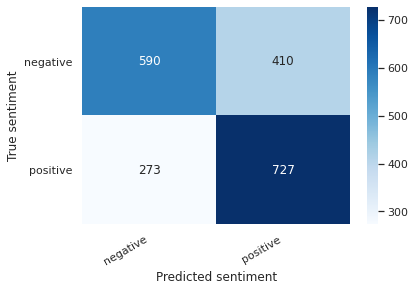

In [ ]:
show_confusion_matrix(y_test.values, preds, class_names=['negative', 'positive'])

In [ ]:
losses = np.array(losses)

In [ ]:
# Find top losses (10)
num_examples = 10

# Find indices of top losses
top_losses_ind = np.argpartition(losses, -num_examples)[-num_examples:]

# Only leave the corresponding predictions
top_losses_preds = preds[top_losses_ind]

In [ ]:
# Show texts with highest losses
top_losses_texts = dublin[~(dublin['sentiment'] == 2)].text.iloc[top_losses_ind]
top_losses_targets = dublin[~(dublin['sentiment'] == 2)].sentiment.iloc[top_losses_ind]

In [ ]:
# Sanity check - all these values should be predicted wrongly
(top_losses_targets == top_losses_preds).mean() # Should output 0.0

0.0

In [ ]:
top_losses_df = dublin.iloc[top_losses_ind][['text','sentiment']]
top_losses_df['prediction'] = top_losses_preds.astype(int)
top_losses_df

,text,sentiment,prediction
1762,"@Taximattdublin @IBIKEDublin @RSAIreland @dublincycling @GardaTraffic @Fingalcoco @DubCityCouncil Nothing wrong with where he is, at some traffic lights I tend to get behind a car to get through the lights rather than risk getting left hooked by one.",0,1
754,The Killer You Never See: Police Are Dying by Suicide More Often Than in the Line of Duty — Why?\n\nA string of police suicides in New York City has put a new spotlight on the issue as Congress moved forward... https://t.co/rJh3W8YOqx,1,0
189,RT @DCCEconDev: Latest Dublin Economic Monitor out now! headlines... employment breeches 700k for 1st time. Unemployment ⤵️ 4.9% Consumer s…,1,0
309,"@ccferrie @hazechu @DubCityCouncil How about cheaper, more wide ranging and more accessible public transport first please please please. So people could actually enjoy this. Nightmare already for people with access issues",1,0
437,@DCarsonArch @ZoeHealy3 @ccferrie You don’t know my LPT in different constituency. Or hardship on elderly. And LPT introduced in recession. And now Govt utterly wasting our high tax on overspend projects. Not on housing. And Council spending fortune on private rentals. So take more from low income hardworkers???,1,0
420,Police search for competent politicians comes up empty https://t.co/til6p6Ov00,1,0
196,13th July 1919\nMullingar\nIn the early hours of the morning a baton charge is made against a group of Sinn Féin supporters in the Westmeath town. Two police officers are hit with revolver shots and are being treated in hospital,1,0
1130,@NursepollyRgn @williamhboney1 @ItsCherrySue @MurphyEoghan @Fingalcoco I agree with Polly Martin. Naming her in her professional capacity and calling out her and FCCs attitude I've no problem with. But tagging her personal account is not right.,0,1
46,Nearly 30pc of homeless people in Ireland living in Dublin inner city – https://t.co/sR4LuWIP1C https://t.co/bpsCKzyiYt https://t.co/6liANSR6J7,1,0
787,We aren't paying doctors.\nOur government cheap skated med lab resulting in 221 women suffering and dying.\nOur hosptials are running on skeleton staff.\n\nMore and more of us are one rent increase from homelessness.\n\nThe only people who benefit are those with wealth and power,1,0


In [ ]:
for i, text in enumerate(top_losses_texts) :
  transformed_texts = np.array([])
  tokens = tokenizer.tokenize(text)

  for token in tokens :
    transformed_texts = np.append(transformed_texts, token)
  
  print('Correct label: ' + f'{top_losses_targets.iloc[i]}\nPrediction: {top_losses_preds[i]}\nText: ' + ' '.join(transformed_texts) + '\n')

Correct label: 0
Prediction: 1.0
Text: @ taxi ##mat ##t ##du ##bl ##in @ ib ##ike ##du ##bl ##in @ rs ##aire ##land @ dublin ##cy ##cl ##ing @ ga ##rda ##tra ##ffi ##c @ fin ##gal ##co ##co @ dub ##city ##co ##un ##ci ##l nothing wrong with where he is , at some traffic lights i tend to get behind a car to get through the lights rather than risk getting left hooked by one .

Correct label: 1
Prediction: 0.0
Text: the killer you never see : police are dying by suicide more often than in the line of duty — why ? a string of police suicide ##s in new york city has put a new spotlight on the issue as congress moved forward . . . https : / / t . co / r ##j ##h ##3 ##w ##8 ##yo ##q ##x

Correct label: 1
Prediction: 0.0
Text: rt @ dc ##ce ##con ##dev : latest dublin economic monitor out now ! headlines . . . employment bree ##ches 700 ##k for 1st time . unemployment [UNK] 4 . 9 % consumer s …

Correct label: 1
Prediction: 0.0
Text: @ cc ##fer ##rie @ haze ##chu @ dub ##city ##co ##un ##ci ##l

# Research questions

In [ ]:
data = [[logreg_accuracy_s140_valid,            bert_accuracy_s140_valid],
        [logreg_accuracy_s140_test_binary,      bert_accuracy_s140_test_binary],
        [logreg_accuracy_s140_test_no_thres,    bert_accuracy_s140_test_no_thres],
        [logreg_accuracy_s140_test,             bert_accuracy_s140_test],
        [logreg_accuracy_dublin_test_binary,    bert_accuracy_dublin_test_binary],
        [logreg_accuracy_dublin_test_no_thres,  bert_accuracy_dublin_test_no_thres],
        [logreg_accuracy_dublin_test_full,      bert_accuracy_dublin_test_full]]

accuracies = pd.DataFrame(data=data, columns=['LogReg', 'BERT'], index=['Sentiment140 validation', 
                                                                        'Sentiment140 test (binary)', 
                                                                        'Sentiment140 test (3 labels) no thres',
                                                                        'Sentiment140 test (3 labels) with thres', 
                                                                        'Dublin test (binary)',
                                                                        'Dublin test (3 labels) no thres',  
                                                                        'Dublin test (3 labels) with thres'])
accuracies

,LogReg,BERT
Sentiment140 validation,0.739182,0.851182
Sentiment140 test (binary),0.768156,0.821229
Sentiment140 test (3 labels) no thres,0.553320,0.591549
Sentiment140 test (3 labels) with thres,0.569416,0.595573
Dublin test (binary),0.667000,0.658500
Dublin test (3 labels) no thres,0.444667,0.439000
Dublin test (3 labels) with thres,0.467000,0.439333


Huge differences in accuracies between Sentiment140 and Dublin City Council datasets can be observed. Reasons:
1. The biggest reason of differences in accuracy is that the training data contains 2 labels, while the test data contains 3 labels (additionally, `neutral`). Although the accuracy was improved a little bit by classifying text as neutral in case when predictions probabilities are close enough to each other, it still suffers a lot from not having been trained on 3 labels.
2. Secondly, the domain is different. Just by looking at the tweets from Sentiment140 dataset, one can see that the language is very informal and oftentimes contains typographic errors. Meanwhile, the Dublin dataset is rather formal and about more "educated" topics, like politics and economy.
3. Hyperlinks are not processed well by both tokenizers: They are divided into symbols like `http`, `:`, `/` that seem to carry meaning while they actually don't.
4. Both models had difficulties recognizing emoticons, although they carry a lot of meaning.
5. Punctuation was rather confusing (**`,`** had negative coefficient in case of Logistic Regression, while **`:`** had a positive one which does not really make sense).

### Accuracy by category - Logistic Regression

In [ ]:
dublin_binary = dublin[dublin.sentiment != 2]

In [ ]:
categories = []
examples = []
accs = []

for category in dublin_binary.category.unique() :
  tweets = dublin_binary[dublin_binary['category'] == category].text
  labels = dublin_binary[dublin_binary['category'] == category].sentiment.values.astype(int)
  n_examples = int(len(tweets))

  X = vectorizer.transform(tweets)
  X = scaler.transform(X.toarray())
  
  preds = log_model.predict(X)
  acc = accuracy_score(labels, preds)

  categories.append(category)
  examples.append(n_examples)
  accs.append(acc)

accs = np.array(accs)
examples = np.array(examples)

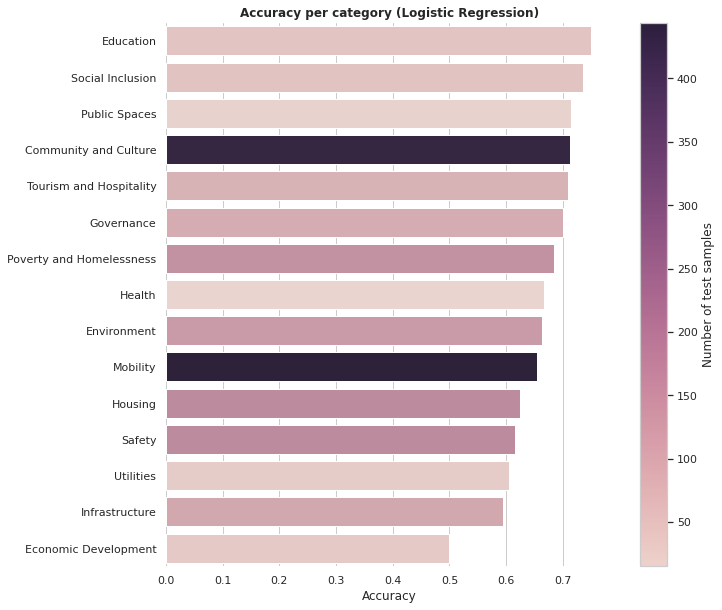

In [ ]:
data = np.concatenate((accs.reshape(15,1), examples.astype(int).reshape(15,1)), axis=1)
accuracies = pd.DataFrame(data=data, columns=['Accuracy', 'n_examples'], index=categories)
accuracies = accuracies.sort_values(by='Accuracy', ascending=False)

fig,ax = plt.subplots(figsize=(10,10))

norm = plt.Normalize(accuracies.n_examples.min(), accuracies.n_examples.max())
cmap = sns.cubehelix_palette(as_cmap=True)

sns.barplot(y=accuracies.index.values, x="Accuracy", data=accuracies, orient='h', ax=ax, palette=cmap(norm(accuracies.n_examples.values)))
sns.despine(left=True, bottom=True)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of test samples', rotation=90)
ax.set_title('Accuracy per category (Logistic Regression)', weight=600)
plt.show();

### Accuracy by category - BERT

In [ ]:
dublin_binary = dublin[dublin.sentiment != 2]

In [ ]:
categories = []
examples = []
accs = []

for category in dublin_binary.category.unique() :
  tweets = dublin_binary[dublin_binary['category'] == category].text.values
  labels = dublin_binary[dublin_binary['category'] == category].sentiment.values.astype(int)
  n_examples = int(len(tweets))
  
  test_input_ids, test_attention_masks, test_labels = encode_data(tweets=tweets, labels=labels)
  temp_dset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
  dl = DataLoader(temp_dset, 
                  sampler=SequentialSampler(temp_dset),
                  batch_size=32)
  
  acc, _ = eval_model(model, dataloader=dl, loss_fn=loss_fn, device=device, n_examples=n_examples)
  acc = acc.item()

  categories.append(category)
  examples.append(n_examples)
  accs.append(acc)

accs = np.array(accs)
examples = np.array(examples)

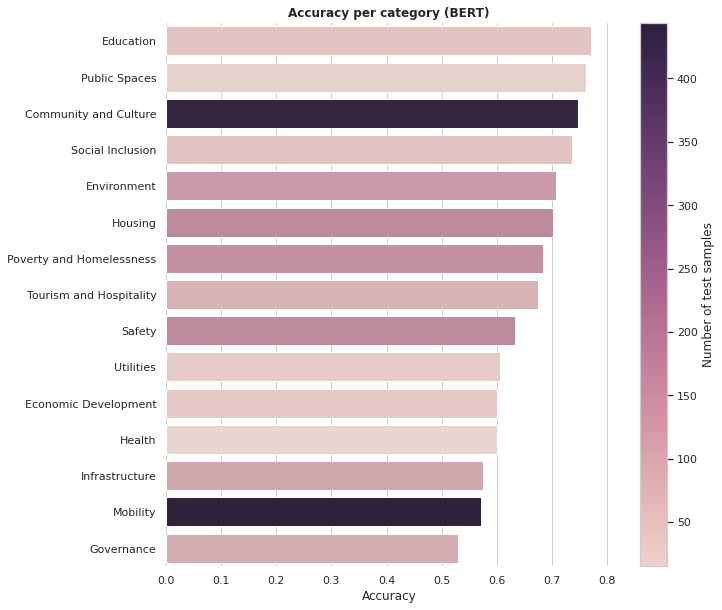

In [ ]:
data = np.concatenate((accs.reshape(15,1), examples.astype(int).reshape(15,1)), axis=1)
accuracies = pd.DataFrame(data=data, columns=['Accuracy', 'n_examples'], index=categories)
accuracies = accuracies.sort_values(by='Accuracy', ascending=False)

fig,ax = plt.subplots(figsize=(10,10))

norm = plt.Normalize(accuracies.n_examples.min(), accuracies.n_examples.max())
cmap = sns.cubehelix_palette(as_cmap=True)

sns.barplot(y=accuracies.index.values, x="Accuracy", data=accuracies, orient='h', ax=ax, palette=cmap(norm(accuracies.n_examples.values)))
sns.despine(left=True, bottom=True)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Number of test samples', rotation=90)
ax.set_title('Accuracy per category (BERT)', weight=600)
plt.show();

Main classification challenges:
- In case of logistic regression, numbers have negative sentiment which does not really make sense.
- While exclamation marks `!` might carry a sentiment of excitement, *commas* `,` do not seem to carry a lot of meaning
- Many emoticons mean the same thing but are not recognized as same. Like `: /` and `:/`. Other emoticons are not recognized at all (like ❤️ ) while they carry a lot of meaning.

Model improvement suggestions:

- First and foremost, the model should be trained on data with 3 labels, not with 2. It might be most helpful to hire some freelancers to annotate neutral tweets as such going through, say, 10,000 training examples.
- Replace hyperlinks with special tokens (like `XXHYPERLINK`).
- Replace all the different numbers with a single token (like `XXNUMBER`).
- Preprocess emojis and convert other html symbols into recognizable tokens (Convert `:)`, `:-)`, `: )`, etc. into the same emoji `:)` and `&#10084;` and `<3` into `xxheart`).
- It would be probably better to remove the remaining punctuation altogether.
- Preprocess references: Treat a reference as one single word, if it does not appear more than X times, replace with a token like `[REF]`, otherwise keep.

In [ ]:
# Code example of possible preprocessing improvements
def additional_preprocess(text) :
  text = re.sub(r'(http|ftp|https):\/\/([\w\-_]+(?:(?:\.[\w\-_]+)+))([\w\-\.,@?^=%&:/~\+#]*[\w\-\@?^=%&/~\+#])?', 'xxhyperlink', text) # replace hyperlinks with special tokens

  text = re.sub(r'\:\)', 'xxsmile', text) # fix emojis
  text = re.sub(r'\=\)', 'xxsmile', text) # fix emojis
  text = re.sub(r'\:\-\)', 'xxsmile', text) # fix emojis
  text = re.sub(r'\:\(', 'xxsad', text) # fix emojis
  text = re.sub(r'\=\(', 'xxsad', text) # fix emojis
  text = re.sub(r'\: \/', 'xsad', text) # fix emojis
  text = re.sub(r'\:\-\(', 'xxsad', text) # fix emojis
  text = re.sub(r'&#10084;', 'xxheart', text) # fix emojis
  text = re.sub(r'&#9829;', 'xxheart', text) # fix emojis
  # ...and so on
  
  text = re.sub(r'[0-9]+', 'xxnumber', text) # replace numbers with special tokens

  text = re.sub(r'[^\w\s]','', text) # remove punctuation

  return text

In [ ]:
text = "Great decision,, South Dublin County Council! :) Walking on Rodes Avenue 33 and loving birds singing in the park! =) https://t.co/T1DH41QVJr"
additional_preprocess(text)

'Great decision South Dublin County Council xxsmile Walking on Rodes Avenue xxnumber and loving birds singing in the park xxsmile xxhyperlink'